In [199]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import model_selection
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import os


In [200]:
MAIN_PATH = os.path.dirname(os.getcwd())
DATA_PATH = MAIN_PATH + "/data/result_df.csv"

MAX_SEQUENCE_LENGTH = 32
METRIC = "w_eda"

## Methods for Plotting with Matplotlib

In this section, we define methods to visualize data distributions using Matplotlib. These methods help in understanding the class distribution before and after applying SMOTE, as well as the distribution of datasets across training, validation, and test sets.

### Plotting Class Distribution Before and After SMOTE

The `plot_smote_class_distribution` function plots the class distribution of the training labels before and after applying SMOTE (Synthetic Minority Over-sampling Technique). This visualization helps in understanding how SMOTE balances the class distribution.


### Plotting Dataset Distribution

The `plot_dataset_distribution` function plots a bar chart showing the sizes of the train, validation, and test sets. This visualization helps in understanding the distribution of samples across different datasets.

These methods provide visual insights into the data, which is crucial for understanding and improving the performance of machine learning models.

In [201]:
def plot_smote_class_distribution(y_train, y_train_resampled):
    """
    Plots the class distribution before and after applying SMOTE.

    Parameters:
    - y_train: Original training labels.
    - y_train_resampled: Training labels after applying SMOTE.
    """
    # Class distribution before SMOTE
    class_distribution_before = Counter(y_train)
    # Class distribution after SMOTE
    class_distribution_after = Counter(y_train_resampled)

    # Define labels
    labels = ['No Stress', 'Stress']

    # Plotting
    plt.figure(figsize=(10, 5))

    # Plot before SMOTE
    plt.subplot(1, 2, 1)
    plt.bar(labels, class_distribution_before.values(), color='blue')
    plt.title('Class Distribution Before SMOTE')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], labels)

    # Plot after SMOTE
    plt.subplot(1, 2, 2)
    plt.bar(labels, class_distribution_after.values(), color='green')
    plt.title('Class Distribution After SMOTE')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], labels)

    plt.tight_layout()
    plt.savefig("../images/preprocessing/SMOTE.png")
    plt.show()
    

In [202]:

def plot_dataset_distribution(x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled, x_test_subject_1, y_test_subject_1, x_test_subject_2, y_test_subject_2):
    """
    Plots a bar chart showing the sizes of the train, validation, and test sets.

    Parameters:
    - x_train, y_train: Training data and labels.
    - x_test_subject_1, y_test_subject_1: Validation data and labels for subject 1.
    - x_test_subject_2, y_test_subject_2: Validation data and labels for subject 2.
    - x_val, y_val: Test data and labels.
    """
    dataset_names = ['Train', 'Test', 'Validation S16', 'Validation S17']
    x_lengths = [len(x_train_resampled), len(x_val_resampled), len(x_test_subject_1), len(x_test_subject_2)]
    y_lengths = [len(y_train_resampled), len(y_val_resampled), len(y_test_subject_1), len(y_test_subject_2)]
    
    # Plotting the bar plot
    plt.figure(figsize=(10, 6))
    
    bar_width = 0.35  # Width of the bars
    
    index = np.arange(len(dataset_names))
    
    plt.bar(index, x_lengths, bar_width, color='b', alpha=0.6, label='X (Features)')
    plt.bar(index + bar_width, y_lengths, bar_width, color='r', alpha=0.6, label='Y (Labels)')
    
    plt.xlabel('Dataset')
    plt.ylabel('Number of Samples')
    plt.title('Dataset Distribution')
    plt.xticks(index + bar_width / 2, dataset_names)
    plt.legend()
    plt.savefig("../images/preprocessing/dataset_distribution.png")
    plt.show()

In [203]:
# Function to load data from CSV or other formats
def load_data(file_path, file_type):
    if file_type == '.csv':
        return pd.read_csv(file_path)
    elif file_type == 'json':
        raise ValueError("Not implemented yet!")
    else:
        raise ValueError("Unsupported file type!")

In [204]:
def filter_subjects(df):
    test_df = df[(df['ID'] == 'S16') | (df['ID'] == 'S17')]

    # Drop the filtered rows from the original DataFrame
    sequences_df = df.drop(test_df.index)

    # Reset index for both DataFrames
    test_df.reset_index(drop=True, inplace=True)
    sequences_df.reset_index(drop=True, inplace=True)

    test_subject_1 = test_df[test_df['ID'] == 'S16']
    test_subject_2 = test_df[test_df['ID'] == 'S17']

    return test_subject_1, test_subject_2, sequences_df


In [205]:
def scale_and_flatten(series_list):
    try:
        scaler = MinMaxScaler()
        return [scaler.fit_transform(np.asarray(series).reshape(-1, 1)).flatten() for series in series_list]
    except Exception as e:
        raise ValueError(f"Failed to scale and flatten series: {e}")


In [206]:
def process_metrics(df, t_df1, t_df2):
    try:
        eda_array_list = scale_and_flatten(df[METRIC].apply(eval))
        test_subject1_array_list = scale_and_flatten(t_df1[METRIC].apply(eval))
        test_subject2_array_list = scale_and_flatten(t_df2[METRIC].apply(eval))

        # Print counts
        print(f"EDA list Count: {len(eda_array_list)}\n Test Subject 1: {len(test_subject1_array_list)} \n Test Subject 2: {len(test_subject2_array_list)} ")
        
        return eda_array_list, test_subject1_array_list, test_subject2_array_list
    except Exception as e:
        raise ValueError(f"Failed to process metrics: {e}")


In [207]:
def pad_and_reshape(series_list, maxlen):
    try:
        padded = pad_sequences(series_list, maxlen=maxlen, dtype='float32', padding='post', truncating='post')
        reshaped = padded.reshape(-1, maxlen, 1)
        return reshaped
    except Exception as e:
        raise ValueError(f"Failed to pad and reshape series: {e}")


In [208]:
def apply_smote(x_train, y_train, x_val, y_val):
    try:
        x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
        x_val_reshaped = x_val.reshape(x_val.shape[0], -1)

        smote = SMOTE(random_state=42)

        # Check the class distribution before SMOTE
        print("Class distribution before SMOTE:", Counter(y_train))

        x_train_resampled, y_train_resampled = smote.fit_resample(x_train_reshaped, y_train)
        x_val_resampled, y_val_resampled = smote.fit_resample(x_val_reshaped, y_val)

        x_train_resampled = x_train_resampled.reshape(-1, x_train.shape[1], x_train.shape[2])
        x_val_resampled = x_val_resampled.reshape(-1, x_train.shape[1], x_train.shape[2])

        # Check the class distribution after SMOTE
        class_distribution_after = Counter(y_train_resampled)
        print("Class distribution after SMOTE:", {0: class_distribution_after[0], 1: class_distribution_after[1]})

        # Call the plot function
        plot_smote_class_distribution(y_train, y_train_resampled)

        return x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled
    except Exception as e:
        raise RuntimeError(f"Failed to apply SMOTE: {e}")


In [209]:
def split_train_and_test (series_list, labels_array):
    # Splitting data into training and validation sets (70% train, 30% validation)
    x_train, x_val, y_train, y_val = model_selection.train_test_split(
        series_list, labels_array, test_size=0.30, random_state=42, shuffle=True
    )

    return x_train, x_val, y_train, y_val

In [210]:
def extract_labels(df, t_df1, t_df2):
    try:
        labels_array = np.array(df['downsampled_label'])
        validation_labels_array_subject_1 = np.array(t_df1['downsampled_label'])
        validation_labels_array_subject_2 = np.array(t_df2['downsampled_label'])
        
        print(
            f"Labels list Count Subject 1: {len(validation_labels_array_subject_1)}\n"
            f"Labels list Count Subject 2: {len(validation_labels_array_subject_2)}"
        )
        
        
        return labels_array, validation_labels_array_subject_1, validation_labels_array_subject_2
    except Exception as e:
        raise ValueError(f"Failed to extract labels: {e}")


In [211]:
def pad_series(eda_array_list, test_subject1_array_list, test_subject2_array_list):
    if not eda_array_list or not test_subject1_array_list or not test_subject2_array_list:
        raise ValueError("Input lists must not be empty")
    
    series_padded = pad_and_reshape(eda_array_list, MAX_SEQUENCE_LENGTH)
    x_test_subject_1_padded = pad_and_reshape(test_subject1_array_list, MAX_SEQUENCE_LENGTH)
    x_test_subject_2_padded = pad_and_reshape(test_subject2_array_list, MAX_SEQUENCE_LENGTH)
    return series_padded, x_test_subject_1_padded, x_test_subject_2_padded


In [212]:
def convert_labels(y_train, y_val, validation_labels_array_subject_1, validation_labels_array_subject_2):
    try:
        y_train = np.asarray(y_train).astype(np.float32)
        y_val = np.asarray(y_val).astype(np.float32)
        y_test_subject_1 = np.asarray(validation_labels_array_subject_1).astype(np.float32)
        y_test_subject_2 = np.asarray(validation_labels_array_subject_2).astype(np.float32)
        return y_train, y_val, y_test_subject_1, y_test_subject_2
    except Exception as e:
        raise ValueError(f"Failed to convert labels: {e}")


In [213]:
def save_datasets(x_train, y_train, x_val, y_val, x_test_1, y_test_1, x_test_2, y_test_2):
    datasets = {
        'x_train': x_train,
        'y_train': y_train,
        'x_val': x_val,
        'y_val': y_val,
        'x_test_1': x_test_1,
        'y_test_1': y_test_1,
        'x_test_2': x_test_2,
        'y_test_2': y_test_2
    }
    
    for name, data in datasets.items():
        np.save(os.path.join(MAIN_PATH, 'data', 'numpy', f'{name}.npy'), data)

In [214]:
def main():
    df = load_data(DATA_PATH,".csv")

    t_df1, t_df2, df = filter_subjects(df)

    eda_array_list, test_subject1_array_list, test_subject2_array_list = process_metrics(df, t_df1, t_df2)

    # Extract labels and convert to numpy arrays
    labels_array, validation_labels_array_subject_1, validation_labels_array_subject_2 = extract_labels(df, t_df1, t_df2)

    # Pad and Reshape the series
    series_padded = pad_and_reshape(eda_array_list, MAX_SEQUENCE_LENGTH)
    x_test_subject_1_padded = pad_and_reshape(test_subject1_array_list, MAX_SEQUENCE_LENGTH)
    x_test_subject_2_padded = pad_and_reshape(test_subject2_array_list, MAX_SEQUENCE_LENGTH)

    # Train-test split
    x_train, x_val, y_train, y_val = split_train_and_test(series_padded, labels_array)

    # Converting labels to numpy arrays
    y_train = np.asarray(y_train).astype(np.float32)
    y_val = np.asarray(y_val).astype(np.float32)
    y_test_subject_1 = np.asarray(validation_labels_array_subject_1).astype(np.float32)
    y_test_subject_2 = np.asarray(validation_labels_array_subject_2).astype(np.float32)

    # Apply SMOTE
    x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled= apply_smote(x_train, y_train, x_val, y_val) 

    #Evaluate dataset distribution
    plot_dataset_distribution(x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled, x_test_subject_1_padded, y_test_subject_1, x_test_subject_2_padded, y_test_subject_2)

    # Save datasets
    save_datasets(x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled, x_test_subject_1_padded, y_test_subject_1, x_test_subject_2_padded, y_test_subject_2)
    
    return x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled, x_test_subject_1_padded, y_test_subject_1, x_test_subject_2_padded, y_test_subject_2


EDA list Count: 9420
 Test Subject 1: 704 
 Test Subject 2: 740 
Labels list Count Subject 1: 704
Labels list Count Subject 2: 740
Class distribution before SMOTE: Counter({0.0: 5856, 1.0: 738})
Class distribution after SMOTE: {0: 5856, 1: 5856}


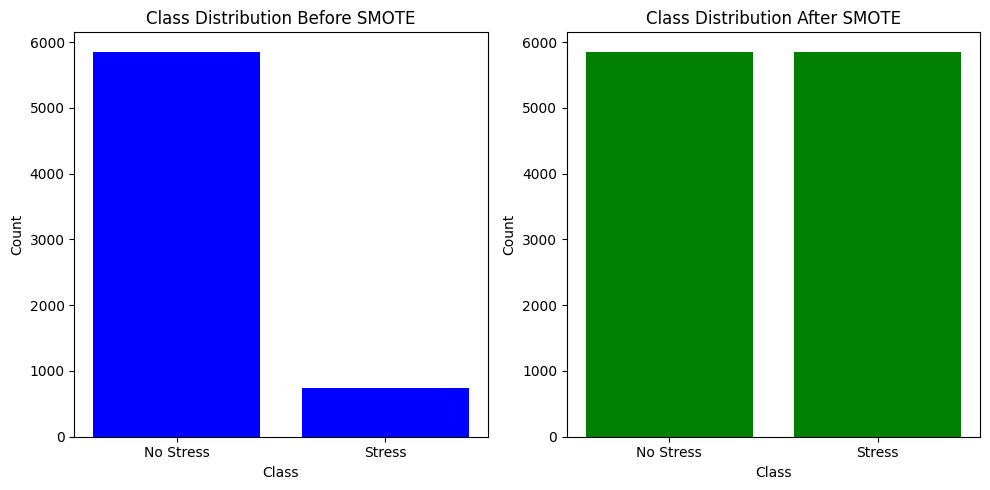

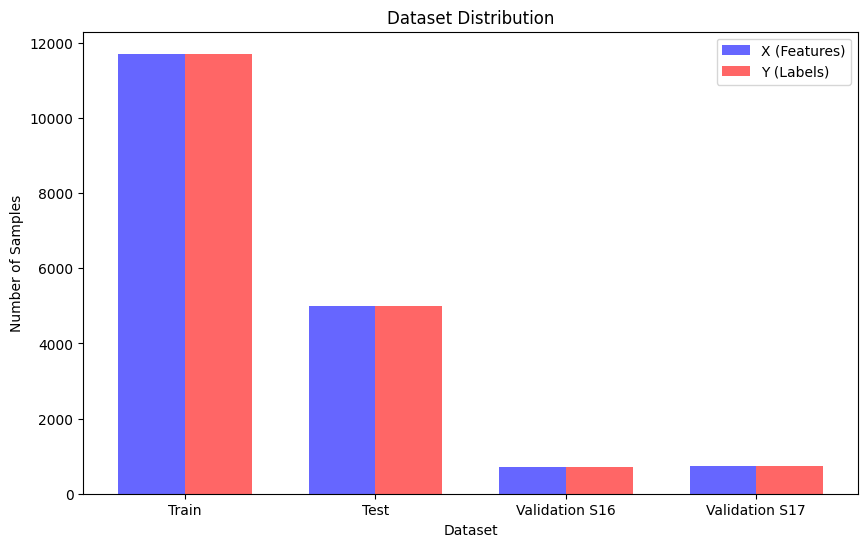

In [215]:
x_train, y_train, x_val, y_val, x_test_1, y_test_1, x_test_2, y_test_2 = main()